In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as scio
import pandas as pd
from scipy.ndimage import gaussian_filter1d


#### Load spiking data and make a dataframe

In [3]:
spike_data = scio.loadmat('D:\\mbl_mouse_2025\\BenIgnitius\\preprocessed\\B4-2025-07-07\\clean_units_imec0.mat')
recording_depth = 5214 # microns 5193 for 7/3; 5214 for 7/7
spike_trains = [x[0].squeeze() for x in spike_data['spike_train'][0]]
unit_depths = recording_depth - spike_data['depths'].squeeze()
unit_ids = np.asarray([x.strip() for x in spike_data['unit_ids'].squeeze()])
unit_waveforms = []
for waveforms in spike_data['mean_waveforms'][0]:
    wave_amps = []
    for ch in range(waveforms.shape[0]):
        wave_amps.append(np.max(waveforms[ch,:]) - np.min(waveforms[ch,:]))
    max_amp_idx = np.argmax(wave_amps)
    unit_waveforms.append(waveforms[max_amp_idx,:])
# Make a dataframe with unit_ids, unit_depths, spike_trains, and unit_waveforms
all_units_df = pd.DataFrame({
    'unit_id': unit_ids,
    'unit_depth': unit_depths,
    'spike_train': spike_trains,
    'unit_waveform': unit_waveforms
})


In [4]:
all_units_df.head()

,unit_id,unit_depth,spike_train,unit_waveform
0,imec0_3,5199.0,"[1.2767, 1.4772, 11.661566666666667, 11.864633...","[-1.5560547, -1.5015625, -1.5439453, -2.264453..."
1,imec0_10,5169.0,"[1.2767333333333333, 1.5212333333333334, 1.703...","[-2.536914, -2.6519532, -2.555078, -3.529883, ..."
2,imec0_11,5169.0,"[0.009866666666666666, 0.0574, 0.1930666666666...","[2.0888672, 2.246289, 2.8759766, 1.8466797, 1...."
3,imec0_14,5184.0,"[3.2917666666666667, 3.4544, 3.579066666666667...","[-3.257422, -3.1363282, -3.29375, -3.3966796, ..."
4,imec0_16,5139.0,"[6.1093, 13.7648, 14.930866666666667, 18.98316...","[-2.5308595, -1.4955078, -1.453125, -1.3017578..."


#### Code to load stimulus presentation times

In [5]:
stim_times = np.loadtxt('D:\\mbl_mouse_2025\\BenIgnitius\\preprocessed\\B4-2025-07-07\\XA1_ON.txt', dtype='float')
con_indices = [1,3,5,7,9,11,13,15,17,19]
pos_indices = [0,6,8,12,16]
neg_indices = [2,4,10,14,18]

#### Code to make single cell peri-event histogram

In [ ]:
# Code to plot trialized rasters for control condition
pre = -10
post = 60
bin_size = 0.1
buffer = 5
bins = np.arange(pre-buffer-bin_size/2, post+buffer+bin_size, bin_size)
control_peths = []
control_trials = []
positive_trials = []
positive_peths = []
negative_trials = []
negative_peths = []
for st in spike_trains:
    trialized_st = []
    # Trialify data for control condition
    for idx in con_indices:
        this_stim = stim_times[idx]
        keep = (st > this_stim+pre-buffer) & (st < this_stim+post+buffer)
        this_trial_st = st[keep]
        this_trial_st -= this_stim
        # bin the spike train
        binned_st = np.histogram(this_trial_st, bins=bins)[0]
        binned_st = binned_st/(1.0*bin_size)
        # Keep bins that correspond to the pre and post time
        binned_st = binned_st[(bins[:-1] >= pre-bin_size/2) & (bins[:-1] <= post+bin_size/2)]
        trialized_st.append(binned_st)
    trialized_st = np.vstack(trialized_st)
    control_trials.append(trialized_st)
    con_peth = np.mean(trialized_st, axis=0)
    control_peths.append(con_peth)
    
    trialized_st = []
    # Get data for postive condition
    for idx in pos_indices:
        this_stim = stim_times[idx]
        keep = (st > this_stim+pre-buffer) & (st < this_stim+post+buffer)
        this_trial_st = st[keep]
        this_trial_st -= this_stim
        # bin the spike train
        binned_st = np.histogram(this_trial_st, bins=bins)[0]
        binned_st = binned_st/(1.0*bin_size)
        # Keep bins that correspond to the pre and post time
        binned_st = binned_st[(bins[:-1] >= pre-bin_size/2) & (bins[:-1] <= post+bin_size/2)]
        trialized_st.append(binned_st)
    trialized_st = np.vstack(trialized_st)
    positive_trials.append(trialized_st)
    pos_peth = np.mean(trialized_st, axis=0)
    positive_peths.append(pos_peth)
    
    trialized_st = []
    # Get data for negative condition
    for idx in neg_indices:
        this_stim = stim_times[idx]
        keep = (st > this_stim+pre-buffer) & (st < this_stim+post+buffer)
        this_trial_st = st[keep]
        this_trial_st -= this_stim
        # bin the spike train
        binned_st = np.histogram(this_trial_st, bins=bins)[0]
        binned_st = binned_st/(1.0*bin_size)
        # Keep bins that correspond to the pre and post time
        binned_st = binned_st[(bins[:-1] >= pre-bin_size/2) & (bins[:-1] <= post+bin_size/2)]
        trialized_st.append(binned_st)
    trialized_st = np.vstack(trialized_st)
    negative_trials.append(trialized_st)
    neg_peth = np.mean(trialized_st, axis=0)
    negative_peths.append(neg_peth)

control_peths = np.vstack(control_peths)
positive_peths = np.vstack(positive_peths)
negative_peths = np.vstack(negative_peths)

In [ ]:
# TODO: ADD SHANK ID
# Adjustable parameters
width_height_ratio = 4  # Adjust this value (higher = wider plots, lower = taller plots)
figure_width = 18  # Total figure width in inches
smoothing_sigma = 1  # Gaussian smoothing parameter (higher = more smoothing)

display_bins = np.arange(pre-bin_size/2, post+bin_size, bin_size)
display_tvec = 0.5*(display_bins[0:-1] + display_bins[1:])
display_tvec.shape

plt.close('all')

# Calculate figure height based on width and desired ratio to make figure wide
figure_height = figure_width / width_height_ratio

# idx = 3  # Change this to view different neurons

# Apply Gaussian smoothing to the data

for idx in np.arange(0,control_peths.shape[0]):
    fig, ax = plt.subplots(1, 3, figsize=(figure_width, figure_height))
    fig.subplots_adjust(wspace=0.3)  # Add space between subplots for wide figure

    control_smoothed = gaussian_filter1d(control_peths[idx,:], sigma=smoothing_sigma)
    positive_smoothed = gaussian_filter1d(positive_peths[idx,:], sigma=smoothing_sigma)
    negative_smoothed = gaussian_filter1d(negative_peths[idx,:], sigma=smoothing_sigma)

    # Plot smoothed data
    ax[0].plot(display_tvec, control_smoothed, label='Control', color='black', linewidth=2)
    ax[0].set_title('Control', fontsize=18)
    ax[0].tick_params(axis='x', labelsize=18)
    ax[0].tick_params(axis='y', labelsize=18)
    ax[0].axvline(0, color='black', linestyle='--', linewidth=1)  # Add vertical line at time 0
    
    for iRow in range(control_trials[idx].shape[0]):
        this_trial = control_trials[idx][iRow,:]
        smoothed_trial = gaussian_filter1d(this_trial, sigma=smoothing_sigma)
        ax[0].plot(display_tvec, smoothed_trial, color='black', linewidth=0.5)

    ax[1].plot(display_tvec, positive_smoothed, label='Positive', color='teal', linewidth=2)
    ax[1].set_title('Positive', fontsize=18)
    ax[1].tick_params(axis='x', labelsize=18)
    ax[1].tick_params(axis='y', labelsize=18)
    ax[1].axvline(0, color='black', linestyle='--', linewidth=1)  # Add vertical line at time 0

    for iRow in range(positive_trials[idx].shape[0]):
        this_trial = positive_trials[idx][iRow,:]
        smoothed_trial = gaussian_filter1d(this_trial, sigma=smoothing_sigma)
        ax[1].plot(display_tvec, smoothed_trial, color='teal', linewidth=0.5)

    ax[2].plot(display_tvec, negative_smoothed, label='Negative', color='orange', linewidth=2)
    ax[2].set_title('Negative', fontsize=18)
    ax[2].tick_params(axis='x', labelsize=18)
    ax[2].tick_params(axis='y', labelsize=18)
    ax[2].axvline(0, color='black', linestyle='--', linewidth=1)  # Add vertical line at time 0
    
    for iRow in range(negative_trials[idx].shape[0]):
        this_trial = negative_trials[idx][iRow,:]
        smoothed_trial = gaussian_filter1d(this_trial, sigma=smoothing_sigma)
        ax[2].plot(display_tvec, smoothed_trial, color='orange', linewidth=0.5)

    # Set same y-axis limits for all subplots using smoothed data
    y_min = min(np.min(control_smoothed), np.min(positive_smoothed), np.min(negative_smoothed))
    y_max = max(np.max(control_smoothed), np.max(positive_smoothed), np.max(negative_smoothed))

    for i in range(3):
        # ax[i].set_ylim(np.floor(y_min), np.ceil(y_max))
        ax[i].set_xlabel('Time from stim presentation (s)', fontsize=18)
        ax[i].set_xlim(pre, post)
        if i == 0:
            ax[i].set_ylabel('Spike Rate (Hz)', fontsize=18)
        else:
            ax[i].set_yticklabels([])   
        # Subplot proportions now controlled by figure dimensions only

    plt.suptitle(f'Unit ID: {unit_ids[idx]}, Depth: {unit_depths[idx]}', fontsize=18)
    plt.tight_layout()
    fig.savefig(f'D:\\mbl_mouse_2025\\BenIgnitius\\figures\\PSTH_{idx}.png')
    plt.close()

#### Heatmap code for each condition

In [ ]:
# Code to plot trialized rasters for control condition
pre = -10
post = 60
bin_size = 0.5
buffer = 5
bins = np.arange(pre-buffer-bin_size/2, post+buffer+bin_size/2, bin_size)
spike_control_peths = []
spike_positive_peths = []
spike_negative_peths = []
for st in spike_trains:
    trialized_st = []
    # Trialify data for control condition
    for idx in con_indices:
        this_stim = stim_times[idx]
        keep = (st > this_stim+pre-buffer) & (st < this_stim+post+buffer)
        this_trial_st = st[keep]
        this_trial_st -= this_stim
        # bin the spike train
        binned_st = np.histogram(this_trial_st, bins=bins)[0]
        binned_st = binned_st/(1.0*bin_size)
        # Keep bins that correspond to the pre and post time
        binned_st = binned_st[(bins[:-1] >= pre) & (bins[:-1] <= post)]
        trialized_st.append(binned_st)
    trialized_st = np.vstack(trialized_st)
    con_peth = np.mean(trialized_st, axis=0)
    spike_control_peths.append(con_peth)
    
    trialized_st = []
    # Get data for postive condition
    for idx in pos_indices:
        this_stim = stim_times[idx]
        keep = (st > this_stim+pre-buffer) & (st < this_stim+post+buffer)
        this_trial_st = st[keep]
        this_trial_st -= this_stim
        # bin the spike train
        binned_st = np.histogram(this_trial_st, bins=bins)[0]
        binned_st = binned_st/(1.0*bin_size)
        # Keep bins that correspond to the pre and post time
        binned_st = binned_st[(bins[:-1] >= pre) & (bins[:-1] <= post)]
        trialized_st.append(binned_st)
    trialized_st = np.vstack(trialized_st)
    pos_peth = np.mean(trialized_st, axis=0)
    spike_positive_peths.append(pos_peth)
    
    trialized_st = []
    # Get data for negative condition
    for idx in neg_indices:
        this_stim = stim_times[idx]
        keep = (st > this_stim+pre-buffer) & (st < this_stim+post+buffer)
        this_trial_st = st[keep]
        this_trial_st -= this_stim
        # bin the spike train
        binned_st = np.histogram(this_trial_st, bins=bins)[0]
        binned_st = binned_st/(1.0*bin_size)
        # Keep bins that correspond to the pre and post time
        binned_st = binned_st[(bins[:-1] >= pre) & (bins[:-1] <= post)]
        trialized_st.append(binned_st)
    trialized_st = np.vstack(trialized_st)
    neg_peth = np.mean(trialized_st, axis=0)
    spike_negative_peths.append(neg_peth)

# Normalize the peths and append them
norm_spike_control_peths = [(x - np.min(x))/(np.max(x) - np.min(x)) for x in spike_control_peths]
spike_control_peths = np.vstack(spike_control_peths)
norm_control_spike_peths = np.vstack(norm_spike_control_peths)

norm_spike_positive_peths = [(x - np.min(x))/(np.max(x) - np.min(x)) for x in spike_positive_peths]
spike_positive_peths = np.vstack(spike_positive_peths)
norm_positive_spike_peths = np.vstack(norm_spike_positive_peths)

norm_spike_negative_peths = [(x - np.min(x))/(np.max(x) - np.min(x)) for x in spike_negative_peths]
spike_negative_peths = np.vstack(spike_negative_peths)
norm_negative_spike_peths = np.vstack(norm_spike_negative_peths)

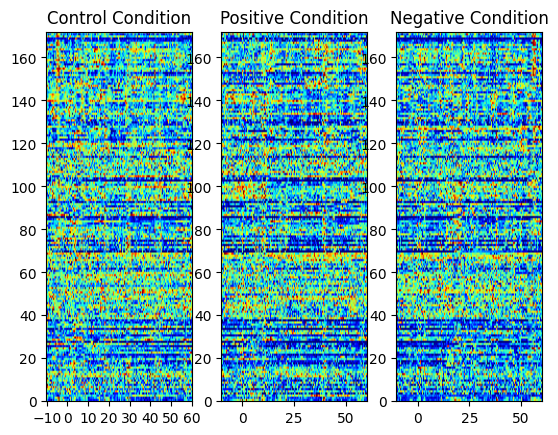

In [24]:
# Plot heatmap for control spike_control_peths after normalizing each row
plt.close('all')
display_bins = np.arange(pre-bin_size/2, post+bin_size, bin_size)
fig, ax = plt.subplots(1,3)
ax[0].imshow(norm_control_spike_peths, aspect='auto', cmap='jet', extent=[display_bins[0], display_bins[-1], 0, spike_control_peths.shape[0]])
ax[1].imshow(norm_positive_spike_peths, aspect='auto', cmap='jet', extent=[display_bins[0], display_bins[-1], 0, spike_positive_peths.shape[0]])
ax[2].imshow(norm_negative_spike_peths, aspect='auto', cmap='jet', extent=[display_bins[0], display_bins[-1], 0, spike_negative_peths.shape[0]])
ax[0].set_title('Control Condition')
ax[1].set_title('Positive Condition')
ax[2].set_title('Negative Condition')
ax[0].set_xticks([-10,0,10,20,30,40,50,60])
ax[0].set_xticks([-10,0,10,20,30,40,50,60])
ax[0].set_xticks([-10,0,10,20,30,40,50,60])

#### Sanity check to see our plotting works

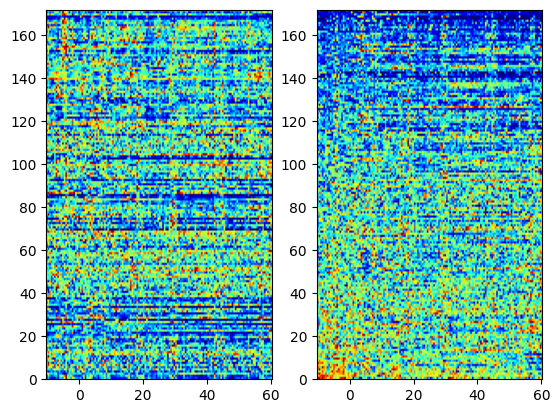

In [ ]:
control_baseline = [np.sum(norm_control_spike_peths[x,0:20]) for x in range(norm_control_spike_peths.shape[0])]
control_sort_idx = np.argsort(control_baseline)
plt.close('all')
display_bins = np.arange(pre-bin_size/2, post+bin_size, bin_size)
fig, ax = plt.subplots(1,2)
ax[0].imshow(norm_control_spike_peths, aspect='auto', cmap='jet', extent=[display_bins[0], display_bins[-1], 0, spike_control_peths.shape[0]])
ax[1].imshow(norm_control_spike_peths[control_sort_idx], aspect='auto', cmap='jet', extent=[display_bins[0], display_bins[-1], 0, spike_control_peths.shape[0]])

#### Make sorted plots

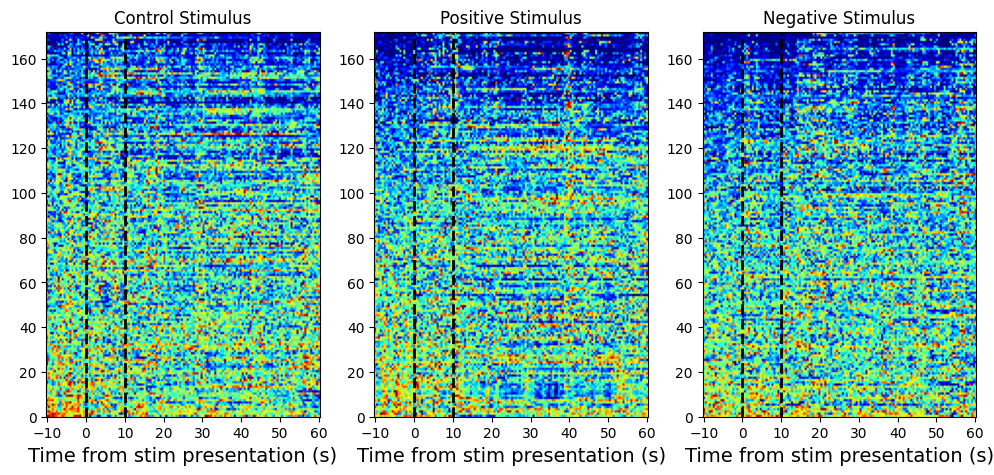

In [62]:
# Plot heatmap for control spike_control_peths after normalizing each row

control_baseline = [np.sum(norm_control_spike_peths[x,0:20]) for x in range(norm_control_spike_peths.shape[0])]
control_sort_idx = np.argsort(control_baseline)
positive_baseline = [np.sum(norm_positive_spike_peths[x,0:20]) for x in range(norm_positive_spike_peths.shape[0])]
positive_sort_idx = np.argsort(positive_baseline)
negative_baseline = [np.sum(norm_negative_spike_peths[x,0:20]) for x in range(norm_negative_spike_peths.shape[0])]
negative_sort_idx = np.argsort(negative_baseline)
plt.close('all')
display_bins = np.arange(pre-bin_size/2, post+bin_size, bin_size)
fig, ax = plt.subplots(1,3, figsize = (12,5))
ax[0].imshow(norm_control_spike_peths[control_sort_idx], aspect='auto', cmap='jet', extent=[display_bins[0], display_bins[-1], 0, spike_control_peths.shape[0]])
ax[1].imshow(norm_positive_spike_peths[positive_sort_idx], aspect='auto', cmap='jet', extent=[display_bins[0], display_bins[-1], 0, spike_positive_peths.shape[0]])
ax[2].imshow(norm_negative_spike_peths[negative_sort_idx], aspect='auto', cmap='jet', extent=[display_bins[0], display_bins[-1], 0, spike_negative_peths.shape[0]])
ax[0].set_title('Control Stimulus')
ax[1].set_title('Positive Stimulus')
ax[2].set_title('Negative Stimulus')
for idx in range(3):
    ax[idx].set_xticks([-10,0,10,20,30,40,50,60])
    ax[idx].axvline(0,ymin=-1, ymax=200,color='black', linewidth=2, linestyle='--')
    ax[idx].axvline(10,ymin=-1, ymax=200,color='black', linewidth=2, linestyle='--')
    ax[idx].set_xlabel('Time from stim presentation (s)', fontsize=14)